# Task 1: Mushroom Classification

- Develop a **Naïve Bayes classifier** from scratch to classify mushrooms using the provided dataset and metadata.
- Split the data into **training (80%)** and **testing (20%)** sets with random sampling (without replacement), ensuring that the **class proportions remain balanced**.
- Assess the classifier's performance by:
  - Plotting the **confusion matrix**
  - Calculating and reporting **precision, recall, and F1-score**


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
from sklearn.metrics import confusion_matrix, classification_report


# Load and Preview the Dataset

Load the mushroom dataset and display the first few rows to get an initial view of the data.


In [20]:
# Load dataset (replace 'mushrooms.csv' with your file name)
df  = pd.read_csv('mushrooms.csv')
# Peek at data
df.head()



,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [21]:
print(df['class'].value_counts())  # To check balance

class
e    4208
p    3916
Name: count, dtype: int64


# Custom Train-Test Split

Split the dataset into training and testing sets while maintaining class balance. Each class is shuffled and divided according to the specified training ratio.


In [22]:
def train_test_split(X, y, train_ratio=0.8):
    np.random.seed(22) 
    
    # Get unique classes
    classes = np.unique(y)
    X_train, X_test, y_train, y_test = [], [], [], []
    
    for c in classes:
        # Get indices for each class
        idx = np.where(y == c)[0]
        np.random.shuffle(idx)
        
        split = int(len(idx) * train_ratio)
        train_idx, test_idx = idx[:split], idx[split:]
        
        X_train.extend(X[train_idx])
        y_train.extend(y[train_idx])
        X_test.extend(X[test_idx])
        y_test.extend(y[test_idx])
    
    return np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)


# Naïve Bayes Classifier Implementation

Define a Naïve Bayes classifier from scratch that can:

- **Fit**: Calculate class priors and feature conditional probabilities with Laplace smoothing.
- **Predict**: Compute the class with the highest posterior probability for each sample using log probabilities to avoid underflow.


In [23]:
class NaiveBayesClassifier:
    def __init__(self):
        self.class_priors = {}
        self.feature_probs = {}
        self.classes = None
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.classes = np.unique(y)
        
        # Count class priors
        class_counts = Counter(y)
        self.class_priors = {c: class_counts[c] / n_samples for c in self.classes}
        
        # Conditional probabilities
        self.feature_probs = {c: [defaultdict(int) for _ in range(n_features)] for c in self.classes}
        
        for xi, label in zip(X, y):
            for j, feature_value in enumerate(xi):
                self.feature_probs[label][j][feature_value] += 1
        
        # Convert counts to probabilities with Laplace smoothing
        for c in self.classes:
            for j in range(n_features):
                total_count = sum(self.feature_probs[c][j].values())
                unique_values = len(self.feature_probs[c][j])
                for val in self.feature_probs[c][j]:
                    self.feature_probs[c][j][val] = (self.feature_probs[c][j][val] + 1) / (total_count + unique_values)
    
    def predict(self, X):
        predictions = []
        for xi in X:
            class_scores = {}
            for c in self.classes:
                # Start with log prior
                score = np.log(self.class_priors[c])
                for j, feature_value in enumerate(xi):
                    prob = self.feature_probs[c][j].get(feature_value, 1e-6)
                    score += np.log(prob)
                class_scores[c] = score
            predictions.append(max(class_scores, key=class_scores.get))
        return np.array(predictions)


# Prepare Data and Train the Model

- Separate the dataset into features and labels.  
- Split the data into training and testing sets using the custom train-test split function.  
- Initialize and train the Naïve Bayes classifier on the training data.  
- Use the trained model to make predictions on the test set.


In [24]:
# Features and labels
X = df.drop("class", axis=1).values
y = df["class"].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, 0.8)

# Train model
nb = NaiveBayesClassifier()
nb.fit(X_train, y_train)

# Predict
y_pred = nb.predict(X_test)



# Evaluate Model Performance

- Compute the **confusion matrix** to visualize prediction accuracy.  
- Print the **classification report** including precision, recall, and F1-score for each class.  
- Plot the confusion matrix as a heatmap to easily interpret the model's predictions versus actual labels.


Classification Report:

              precision    recall  f1-score   support

           e       0.99      1.00      0.99       842
           p       1.00      0.99      0.99       784

    accuracy                           0.99      1626
   macro avg       0.99      0.99      0.99      1626
weighted avg       0.99      0.99      0.99      1626



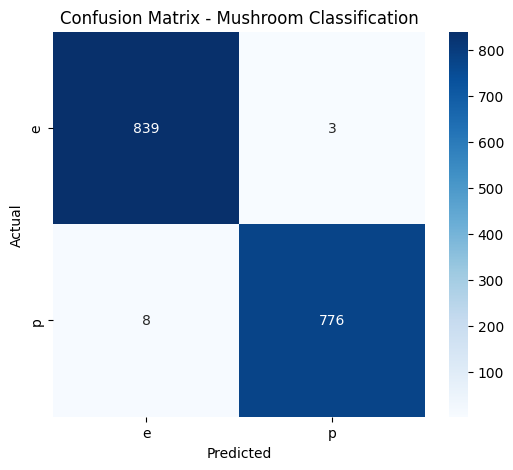

In [25]:

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))

# Print classification report (precision, recall, F1)
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=np.unique(y)))

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=np.unique(y), 
            yticklabels=np.unique(y))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Mushroom Classification")
plt.show()
